# Projeto 3 : Mecânica dos Fluidos

 
 O número de Reynolds,$Re$, é uma quantidade adimensional da mecânica dos fluidos usada para prever padrões de deslocamento do fluido em diferente situações de fluxo. 
 
 Ele é definido como: $Re = \frac{\rho u L}{\mu}$
     
 onde $\rho$ é a densidade do fluido, $u$ é a velocidade do fluido com respeito ao objeto, $L$ é a dimensão linear característica e $\mu$ é a viscosidade dinâmica.
 Logo o número de Reynolds quantifica a razão entre as forças inerciais e forças viscosas do fluido.
 Existem dos tipos de regime de deslocamento de um fluido:
 
 $\cdot$ Fluxo laminar: Ocorre em baixos valores do número de Reynolds, ou seja, quando as forças viscosas do fluido são dominates.
 
 $\cdot$ Fluxo turbulento: Ocorre em altos valores do número de Reyndols, ou seja, quando as forças inercias são dominantes.

 O fluxo turbulento é caracterizado por pequenos vortexs depois do objeto, como pode ser visto na referência [1].
 Espera-se que para números de Reynolds pequenos o fluxo seja laminar, com apenas pequenos valores de vorticidade em torno das partes superiores e inferiores do objeto. Para um fluxo sobre um objeto circular( ou cilíndrico) os
 intervalos de Re para os diferentes regimes são,aproximadamente:
 
 $\cdot$ Fluxo laminar:$Re \leq 2300$
 
 $\cdot$ Transição entre laminar e turbulento: $ 2300 < Re \leq 4000$
 
 $\cdot$ Fluxo turbulento:$Re > 4000$
 
 Como o fluxo desta simulação é feito sobre um objeto retangular, espera-se que esses limites não sejam o mesmo. Mas para fins de comparação eles serão úteis para obter-se ,através da simulação, experimentando diversos números de Reynolds.
 
 Abaixo se encontra o código usado para simular o problema:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulation(Nx,Ny,nt,nw,e,xobs,w,Re): # função que realiza a simulação
    
        count = 0 # variável que conta o número de iterações realizadas até a convergência
        R = Re/(2*nw) # conversão do número de Reynolds físico para o da malha
        
        zero_r = np.zeros((1,Ny+1)) #matrizes linha e coluna nulas para o calculo dos novos psi's e zeta's
        zero_c = np.zeros((Nx+1,1))
        zeta = np.zeros((Nx+1,Ny+1)) # matrizes de psi e zeta 
        psi = np.ones((Nx+1,Ny+1))
        # coordenada x, abaixo a inicialização da matriz psi(velocidades somente na direção x)
        for i in range(0,Ny+1):
            psi[:,i]=i*psi[:,i]
        maxdif = True # variável booleana para a condição de parada do loop
        
        psi,qsi = bound_cond(psi,zeta,Nx,Ny,nt,nw,xobs) 
        
        while maxdif:
            
            ''' A função "zeros" realiza o deslocamento das linhas e colunas da matriz, de modo que, anexando
            a matriz zero_c no lado direito dela, por exemplo, e excluindo a primeira coluna estará se pegando 
            a coluna logo à direita,ou seja a coluna j+1. Anexando do outro lado, e excluindo a última coluna
            estará se pegando a coluna à esquerda, ou seja, a j-1. O raciocínio é o mesmo para as linhas,onde 
            se usa a matriz linha de zeros, ao invés da coluna. Ao somar as matrizes retornadas pela função
            estar-se-á somando os elementos acima,abaixo,à esquerda e à direita de um dado elemento ij.'''
            
            psi_uz,psi_dz,psi_lz,psi_rz = zeros(psi,zero_r,zero_c,Nx,Ny)
            
            zeta_uz,zeta_dz,zeta_lz,zeta_rz = zeros(zeta,zero_r,zero_c,Nx,Ny)
         
            new_psi = (1/4)*(psi_lz + psi_rz + psi_uz + psi_dz - zeta)
                    
            new_psi = mix(psi,new_psi,w)# aqui realiza-se a mistura dos psi's
            
            new_psi,zeta = bound_cond(new_psi,zeta,Nx,Ny,nt,nw,xobs) # aplicação das condições de contorno
            
            if np.all(abs(new_psi-psi)<=e):# a condição de parada é que a diferença entre os novos psi e psi 
                                           #seja menor ou igual que "e", para todo valor de psi.
                maxdif = False
                
            psi = new_psi
            
            # mesmo processo para a primeira parte do cálculo do novos zeta's
            
            new_zeta = zeta_uz + zeta_dz + zeta_lz + zeta_rz
            
            #cálculo das novas matrizes deslocadas de psi necessárias para o cálculo de zeta
            psi_uz,psi_dz,psi_lz,psi_rz = zeros(psi,zero_r,zero_c,Nx,Ny)  
            new_zeta_2 = (1/4)*(new_zeta - (R/4)*((psi_rz-psi_lz)*(zeta_dz-zeta_uz) - (psi_dz-psi_uz)*(zeta_rz-zeta_lz)))
            
            zeta = np.copy(mix(zeta,new_zeta_2,w)) # aqui se realiza as misturas dos novos valores de zeta com os antigos
            
            count = count + 1
            
        psi= np.c_[psi[:,::-1],psi] # Anexando a matriz de psi ao contrário a ela mesma para obter a
        zeta= np.c_[zeta[:,::-1],zeta] # geometria completa do problema. O mesmo para zeta.
        print(count,'\n')    
        return psi,zeta
    
def mix(fi,fi_linha,w): #função que mistura os fi's 
    
    return (1-w)*fi + w*fi_linha     

def bound_cond(psi,zeta,Nx,Ny,nt,nw,xobs):# função que ajusta as condições de contorno
         
        psi[0,:] = psi[1,:] # borda esquerda para psi e zeta
        zeta[0,:] = 0
        psi[Nx,:] = psi[Nx-1,:] # borda direita
        zeta[Nx,:] = zeta[Nx-1,:] # borda direita para zeta
        psi[:,Ny] = psi[:,Ny-1] + 1 # borda superior
        psi[:,0] = 0 # borda inferior (eixo x) = 0 
        zeta[:,0] = 0 # zeta na borda inferior
        zeta[:,Ny] = 0 # zeta = 0 na borda superior

        #condições de contorno para as bordas  do objeto
        
        zeta[xobs-1,0:nw+1]= 2*psi[xobs-2,0:nw+1] # borda esquerda
        zeta[xobs+nt+1,0:nw+1] = 2*psi[xobs+nt+2,0:nw+1] # borda direita
        psi[xobs+nt+1,0:nw+1] = 0 # condição para que psi seja nulo nas beiradas esquerda e direita do objeto
        psi[xobs-1,0:nw+1] = 0
        zeta[xobs-1:xobs+nt+2,nw+1] = 2*psi[xobs-1:xobs+nt+2,nw+2] # condição de contorno para a borda superior do objeto
        psi[xobs-1:xobs+nt+2,nw+1] = 0 # condição para psi = 0 na borda superior do objeto
            
        return psi,zeta
    
def zeros(fi,zero_r,zero_c,Nx,Ny): # função que retorna as novas matrizes para as linhas acima e a baixo
                                    # e colunas à esquerda e à direita
        
    # a função np.r_ anexa linhas e a função np.c_ anexa colunas
    fi_uz = np.r_[zero_r,fi] # matrizes psi com uma linha de zeros em cima e embaixo respectivamente
    fi_uz = np.delete(fi_uz,(Nx+1),axis=0) # fi(i-1,j)
                                            
    fi_dz = np.r_[fi,zero_r]
    fi_dz = np.delete(fi_dz,(0),axis=0) # fi(i+1,j)
            
    fi_lz = np.c_[zero_c,fi] # matrizes psi com uma linha de zeros à esquerda e à direita respectivamente
    fi_lz = np.delete(fi_lz,(Ny+1),axis=1) #fi(i,j-1)
                                                
    fi_rz = np.c_[fi,zero_c]
    fi_rz = np.delete(fi_rz,(0),axis=1) #fi(i,j+1)
    
    return fi_uz,fi_dz,fi_lz,fi_rz

def plot(psi,zeta): #função para realizar o plot dos resultados de psi e zeta
    
    plt.figure(figsize=(15,13))

    plt.subplot(2, 2, 1)
    plt.pcolor(psi.T)
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.pcolor(zeta.T)
    plt.colorbar()

No código abaixo foi realizado a simulação para $Re = 0.1$, numa malha 100x100 com um objeto de tamanho 10x10, colocado a uma distância de 20 do eixo y. Espera-se que nesse regime o fluxo seja laminar,já que o número de Reynolds é pequeno. Comparativamente, realizou-se a simulação com dois valores para $\omega$, o fator de relaxamento.

12380 

5971 



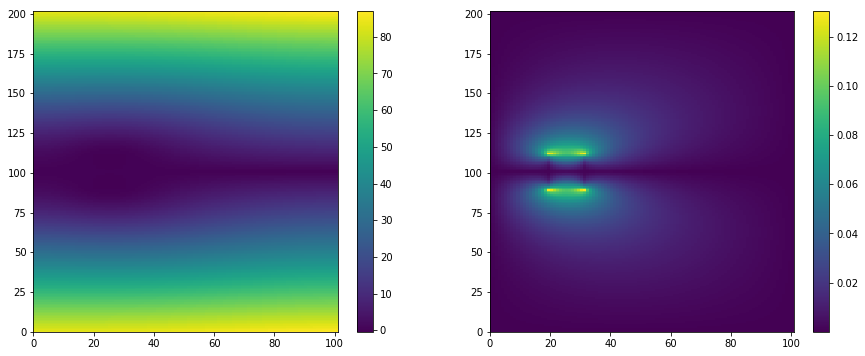

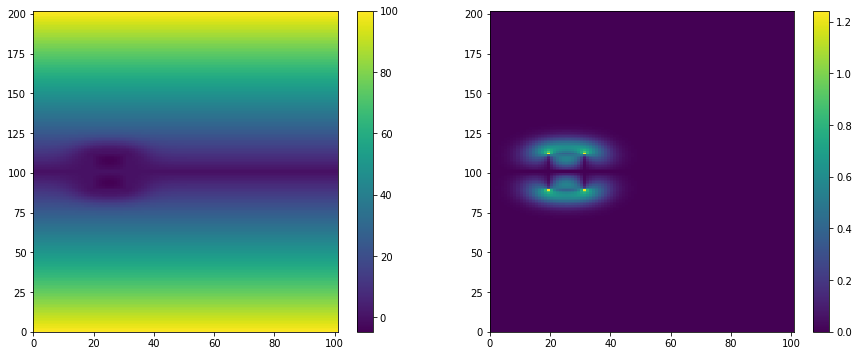

In [16]:
psi,zeta = simulation(100,100,10,10,0.001,20,0.9,0.1)
psi1,zeta1 = simulation(100,100,10,10,0.001,20,0.01,0.1)
plot(psi,zeta)
plot(psi1,zeta1)


 Dos gráficos vê-se que os resultados corresponde ao esperado, já que em $\psi$, há um deslocamento do fluxo do fluido em torno do objeto e para $\zeta$ ocorreu valores não nulos de vorticidade em torno da parte superior, como seria esperado já que a velocidade do flúido nessa região teria uma componente na direção de $y$.
 
 Vê-se que o número de iterações para $\omega = 0.9$ é maior, comparado a $\omega = 0.01$, o que pode ser usado como explicação para as diferenças obtidas nos resultados. Vê-se que a convergência se realizou mais rapidamente para o segundo caso, já que com um $\omega$ menor, a cada iteração os valores novos de $\psi$ e $\zeta$ são mais parecidos com os anteriores. Porém, o segundo resultado está mais próximo do esperado.
 
 Abaixo foi realizado a mesma simulação porém com uma precisão maior:

34919 

67582 



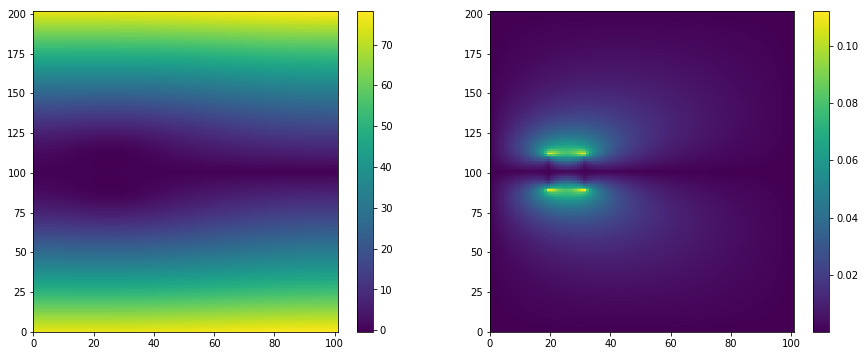

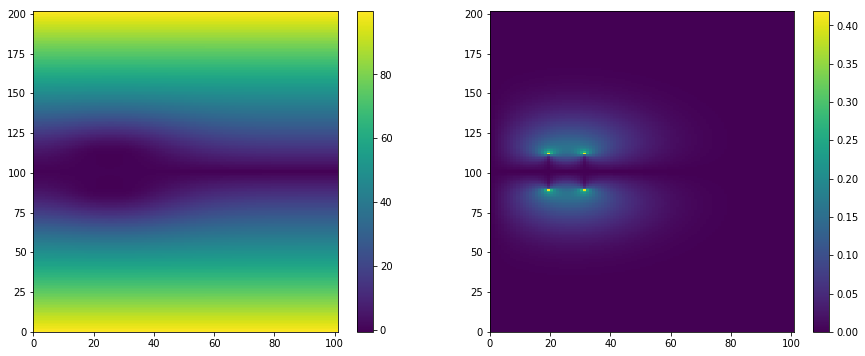

In [17]:
psi,zeta = simulation(100,100,10,10,0.0001,20,0.9,0.1)
psi1,zeta1 = simulation(100,100,10,10,0.0001,20,0.01,0.1)
plot(psi,zeta)
plot(psi1,zeta1)


 Vê-se que ambos começam a ficar parecidos, logo o limite superior para o fator de relaxamento já é o suficiente para dizer que houve convergência,na precisão de 0.001.

No código abaixo foi realizado a simulação para $Re = 1$, na mesma configuração anterior. Espera-se que nesse regime o fluxo também seja laminar,já que o número de Reynolds ainda é pequeno. Comparativamente, o resultado não deve mudar demais em relação ao resultado anterior:

12374 

5964 



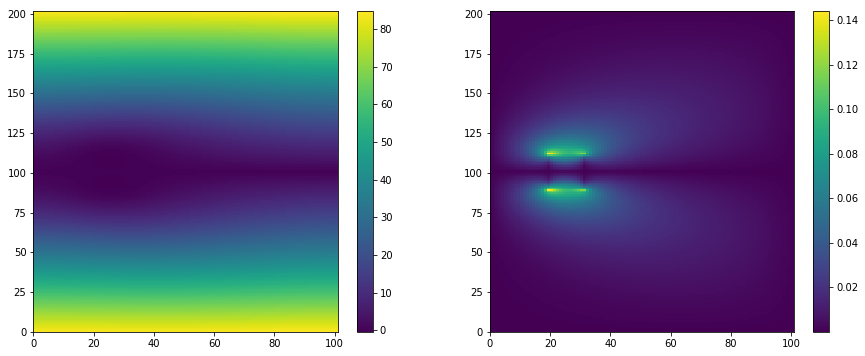

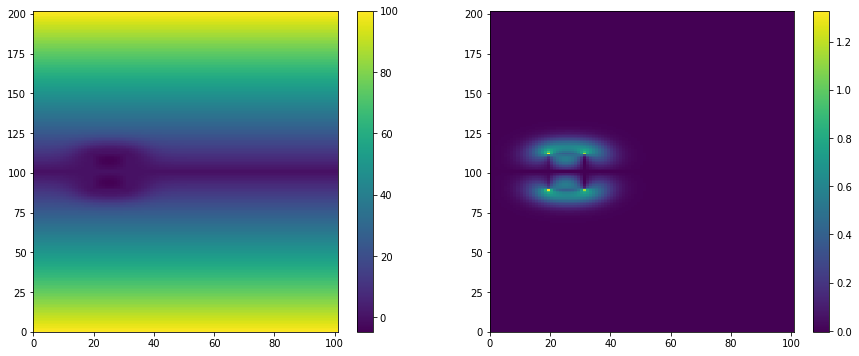

In [13]:
psi,zeta = simulation(100,100,10,10,0.001,20,0.9,1)
psi1,zeta1 = simulation(100,100,10,10,0.001,20,0.01,1)
plot(psi,zeta)
plot(psi1,zeta1)

 As mesmas conclusões que a simulação podem ser retiradas. Abaixo um teste com uma precisão maior:

34090 

68771 



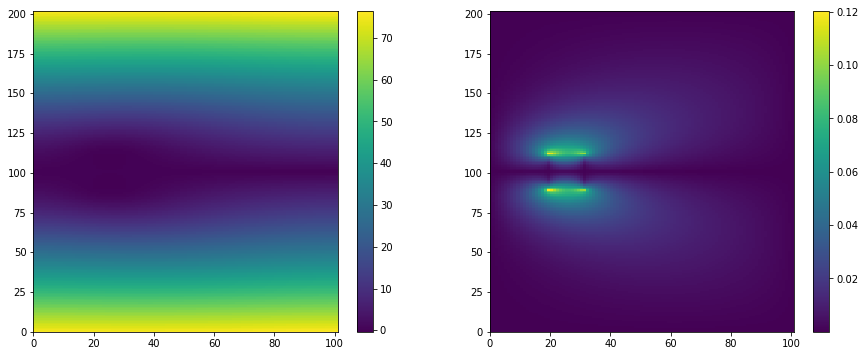

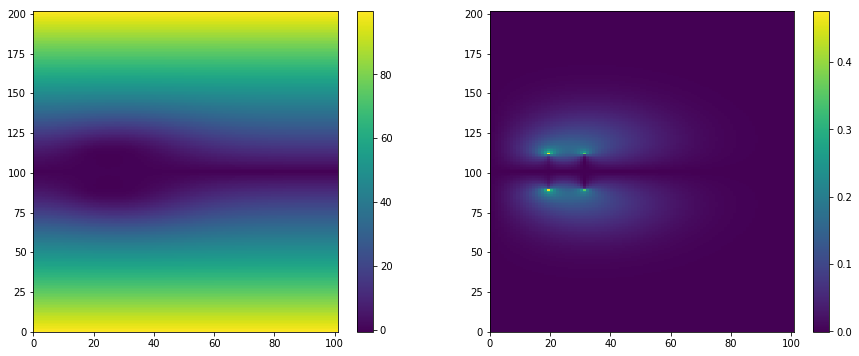

In [18]:
psi,zeta = simulation(100,100,10,10,0.0001,20,0.9,1)
psi1,zeta1 = simulation(100,100,10,10,0.0001,20,0.01,1)
plot(psi,zeta)
plot(psi1,zeta1)

 Abaixo foi realizado uma simulação nas mesmas configurações geométricas que a anterior, com  $Re = 10$ e $\omega = 0.1$ e $\omega = 0.01$. Tais ômegas usados foram os limites superiores e inferiores encontrados que garantiam uma convergência.

7440 

7462 



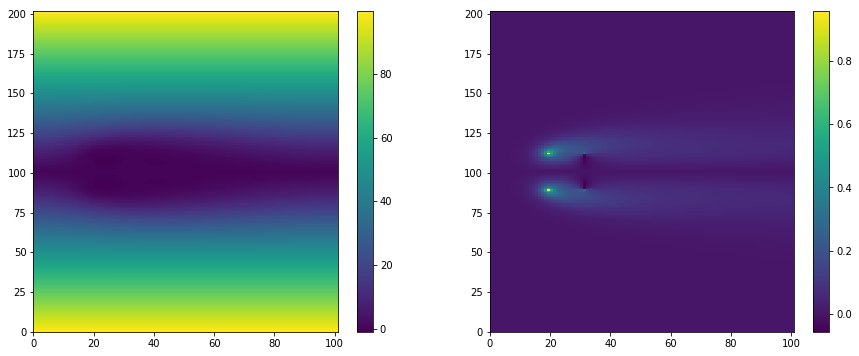

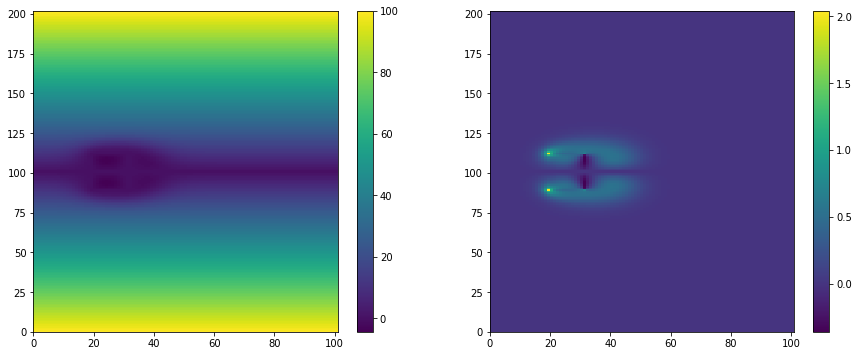

In [21]:
psi,zeta = simulation(100,100,10,10,0.001,20,0.1,10)
psi1,zeta1 = simulation(100,100,10,10,0.001,20,0.01,10)
plot(psi,zeta)
plot(psi1,zeta1)

 Vê-se que para $Re = 10$ está ocorrendo algum tipo de transição no tipo do fluxo. Já que há uma protuberância maior de $\psi$ no lado direito do objeto. Em $\zeta$ a vorticidade está maior e também mais concentrada e espalhada para a direita. Este caso está de acordo com o esperado, pois isto indica que as forças inerciais do fluido esta se tornando maior comparativamente às forças viscosas do mesmo, o que explica a pequena "demora" para a laminarização após o objeto.
 Abaixo é realizado uma simulação com uma precisão maior.
 
(Obs: Pelo número de iterações não recomendo rodar novamente,já que demorou um tempo considerável).

85405 

74534 



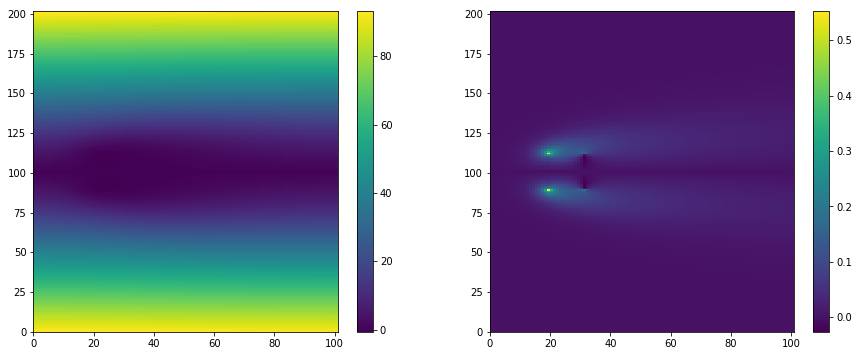

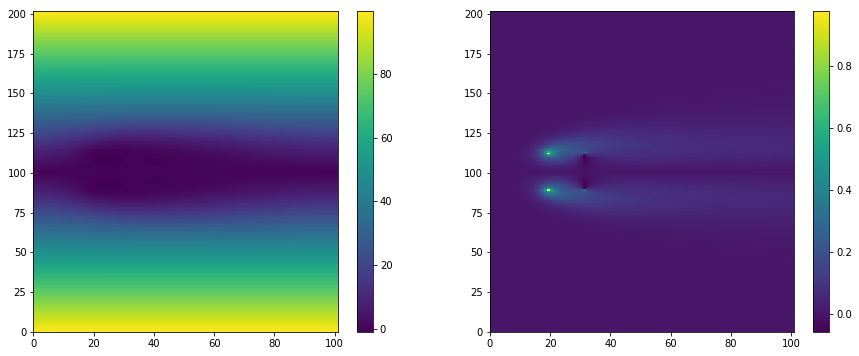

In [10]:
psi,zeta = simulation(100,100,10,10,0.0001,20,0.1,10)
psi1,zeta1 = simulation(100,100,10,10,0.0001,20,0.01,10)
plot(psi,zeta)
plot(psi1,zeta1)

 Abaixo o código realizará a simulação para $Re=100$. Espera-se que os efeitos observados na simulação anterior se amplifiquem:

14205 

13032 



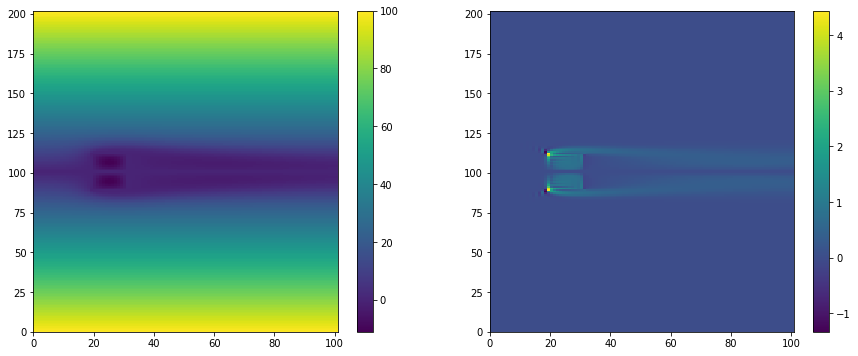

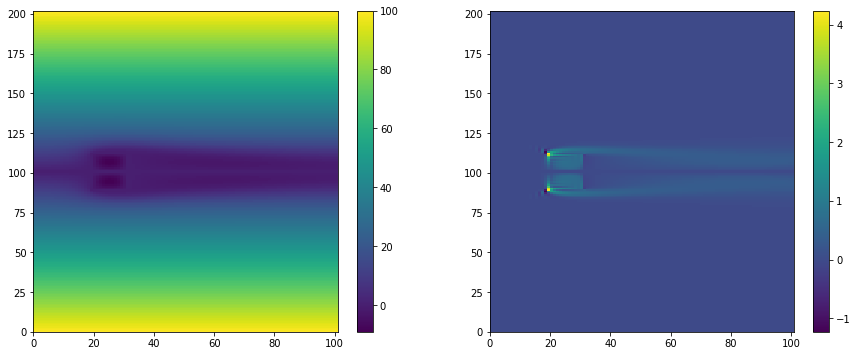

In [9]:
psi,zeta = simulation(100,100,10,10,0.001,20,0.008,100)
psi1,zeta1 = simulation(100,100,10,10,0.001,20,0.01,100)
plot(psi,zeta)
plot(psi1,zeta1)


 Como o esperado os efeitos foram amplificados. O gráfico de $\psi$ indica que a inércia do líquido está maior, já que há uma quantidade maior de fluido está tendendo a se manter no fluxo que atravessa o objeto, ao invés de logo após atravessá-lo tender ao fluxo inicial na região- comparativamente aos casos anteriores onde a viscosidade do fluido era consideravelmente maior que a inércia.
 Também é importante notar que neste caso os valores de ômega usados para as simulações são bem menores,já que fora desse intervalo não ocorre a convergência;o que indica que é necessário realizar uma simulação com uma precisão maior para que se confirme que não haverá mudanças após mais iterações.
 
 Abaixo a simulação com uma precisão maior:

57818 

57952 



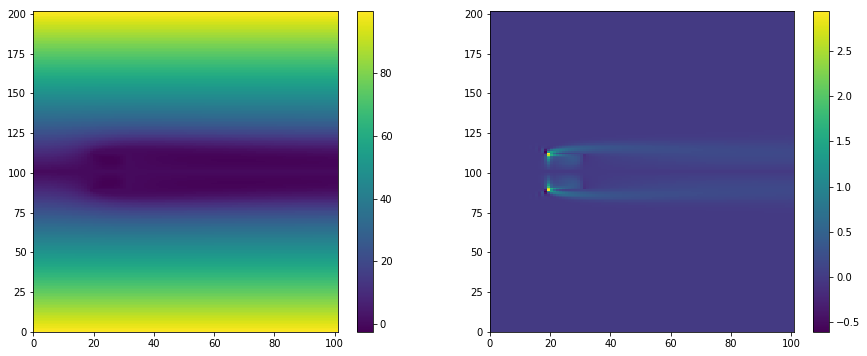

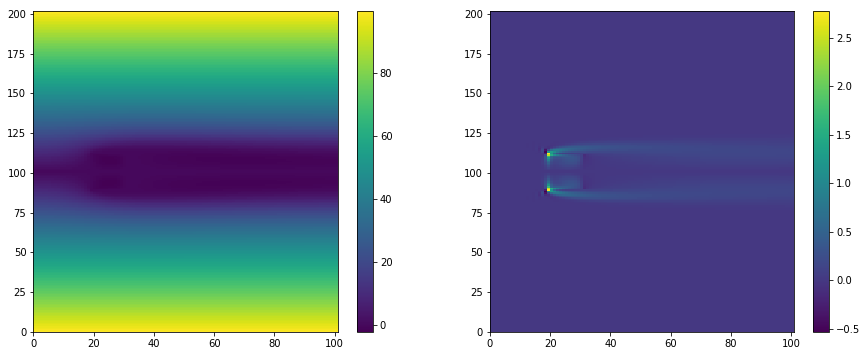

In [14]:
psi,zeta = simulation(100,100,10,10,0.0001,20,0.008,100)
psi1,zeta1 = simulation(100,100,10,10,0.0001,20,0.01,100)
plot(psi,zeta)
plot(psi1,zeta1)

plt.savefig('seila.jpg')

 Vê-se que houve uma pequena mudança no fluxo após o objeto e também nos valores de $\zeta$, como é percebido pela escala. Logo este resultado deve representar melhor o esperado.

Abaixo foi realizado uma simulacão para $Re = 250$. Para valores grandes de $Re$, encontra-se uma dificuldade para realizar uma simulação que convirja, já que os valores de $\omega$ necessários se tornam cada vez menores; o que pode levar a simulação convergir antes do esperado:

24365 



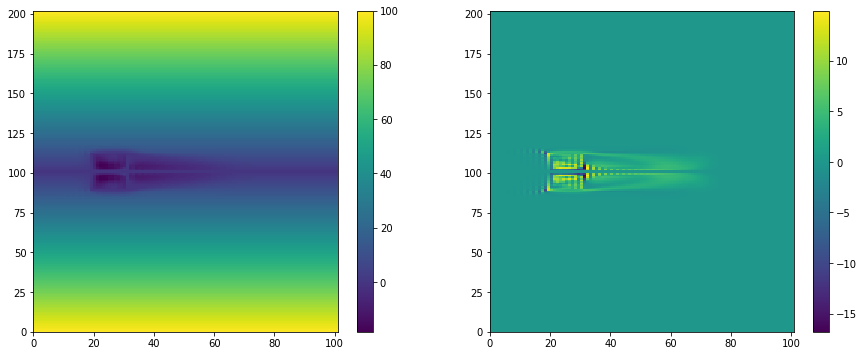

In [28]:
psi,zeta = simulation(100,100,10,10,0.001,20,0.0005,250)
#psi1,zeta1 = simulation(100,100,10,10,0.01,20,1,0.01)
plot(psi,zeta)


 Tentei realizar uma simulação com mais precisão e que convergisse porém não obtive sucesso (O mesmo para os de baixo). 
 
 Dos gráficos de $\psi$ e $\zeta$, vê-se que os efeitos do aumento das forças inerciais foram amplificados, o que leva a um aumento dos valores de vorticidade entorno do objeto. Também vê-se que esse aumento da vorticidade se propaga na direção do fluxo do fluido, como seria esperado num regime de transição entre o laminar e o turbulento. Também ocorreu um efeito novo no lado esquerdo do objeto para $\zeta$, o que pode ser explicado pelo regime de transição ou pelo fato de que o valor de $\omega$ usado foi pequeno e talvez com um número maior de iterações o efeito sumiria (apesar de que o número de iterações foi grande, o que pode indicar que seja realmente esperado).

 Abaixo realizou-se uma simulação na mesma geometria dos anteriores, porém com $Re = 350$:

27085 



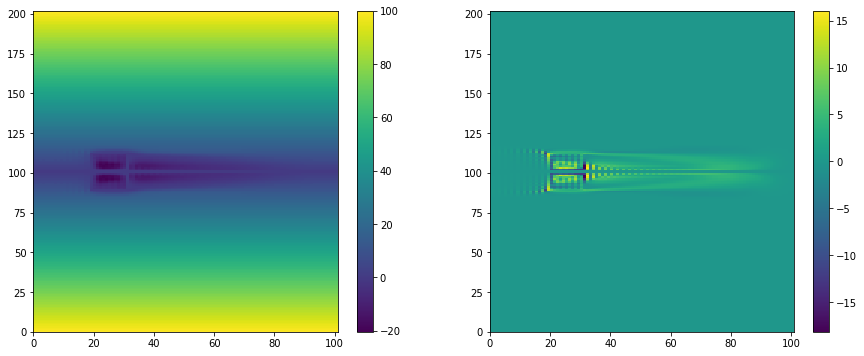

In [30]:
psi,zeta = simulation(100,100,10,10,0.001,20,0.0005,350)
#psi1,zeta1 = simulation(100,100,10,10,0.01,20,1,0.01)
plot(psi,zeta)


 Como esperado, vê-se que os efeitos se amplificaram, assim como os valores de vorticidade.

Abaixo foi realizado uma simulação com uma geometria diferente, porém de forma que o número de Reynolds da malha seja equivalente ao caso de $Re = 10$ com um objeto de $nw = 10$. Com $Re = 20$ e $nw = 20$, o valor de R será 0.5. Espera-se que os resultados sejam o mesmo:

11998 



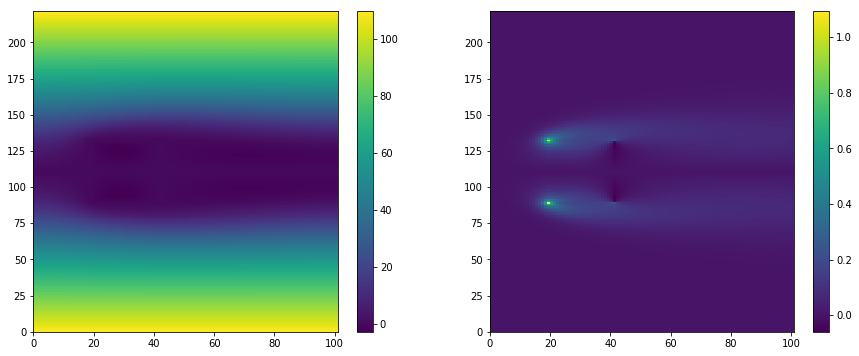

In [17]:
psi,zeta = simulation(100,110,20,20,0.001,20,0.1,20)
plot(psi,zeta)

 Comparando com o resultado obtido no caso do objeto 10x10, vê-se que ambos estão bem parecidos. O que indica que a simulação está correta.

Para valores de $Re > 450$ os resultados são insatisfatórios. Com uma pequena precisão e um valor de $\omega$ adequado o número de iterações não é o suficiente para a convergência. Aumentando o tamanho da malha, obtêm-se os mesmos resultados, praticamente, e com um tamanho grande de malha(cerca de 600x600) a simulação não converge e resulta em overflows.

# Referências:
[1] https://en.wikipedia.org/wiki/Reynolds_number#cite_note-De_Witt_1990-15

[2] https://www.uio.no/studier/emner/matnat/math/MEK4450/h11/undervisningsmateriale/modul-5/Pipeflow_intro.pdf

[3] Koonin, Steven E - Computational Physics _ Fortran Version (2018, Chapman and Hall_CRC)